In [1]:
# Import necessary libraries for deep learning and computer vision
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from PIL import Image
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050


In [2]:
# Define dataset path
dataset_path = r"C:\Users\isuru\Downloads\Vision/PlantVillage"

# Extract class names from directory structure
class_names = sorted(os.listdir(dataset_path))
class_names = [name for name in class_names if not name.startswith('.')]
num_classes = len(class_names)

print(f"Number of disease classes: {num_classes}")
print("\nSample disease classes:")
for i, name in enumerate(class_names[:8]):
    print(f"  {i+1}. {name.replace('___', ': ').replace('_', ' ')}")

Number of disease classes: 15

Sample disease classes:
  1. Pepper  bell: Bacterial spot
  2. Pepper  bell: healthy
  3. Potato: Early blight
  4. Potato: Late blight
  5. Potato: healthy
  6. Tomato Bacterial spot
  7. Tomato Early blight
  8. Tomato Late blight


In [3]:
# Count images per class
image_distribution = {}
total_count = 0

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    image_list = [f for f in os.listdir(class_folder) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    count = len(image_list)
    image_distribution[class_name] = count
    total_count += count

print("="*70)
print("DATASET ANALYSIS")
print("="*70)
print(f"Total images: {total_count:,}")
print(f"Mean images per class: {total_count // num_classes:,}")

sorted_distribution = sorted(image_distribution.items(), key=lambda x: x[1], reverse=True)
print(f"\nClass with maximum images: {sorted_distribution[0][0]}")
print(f"  Count: {sorted_distribution[0][1]:,}")
print(f"Class with minimum images: {sorted_distribution[-1][0]}")
print(f"  Count: {sorted_distribution[-1][1]:,}")

DATASET ANALYSIS
Total images: 20,638
Mean images per class: 1,375

Class with maximum images: Tomato__Tomato_YellowLeaf__Curl_Virus
  Count: 3,208
Class with minimum images: Potato___healthy
  Count: 152


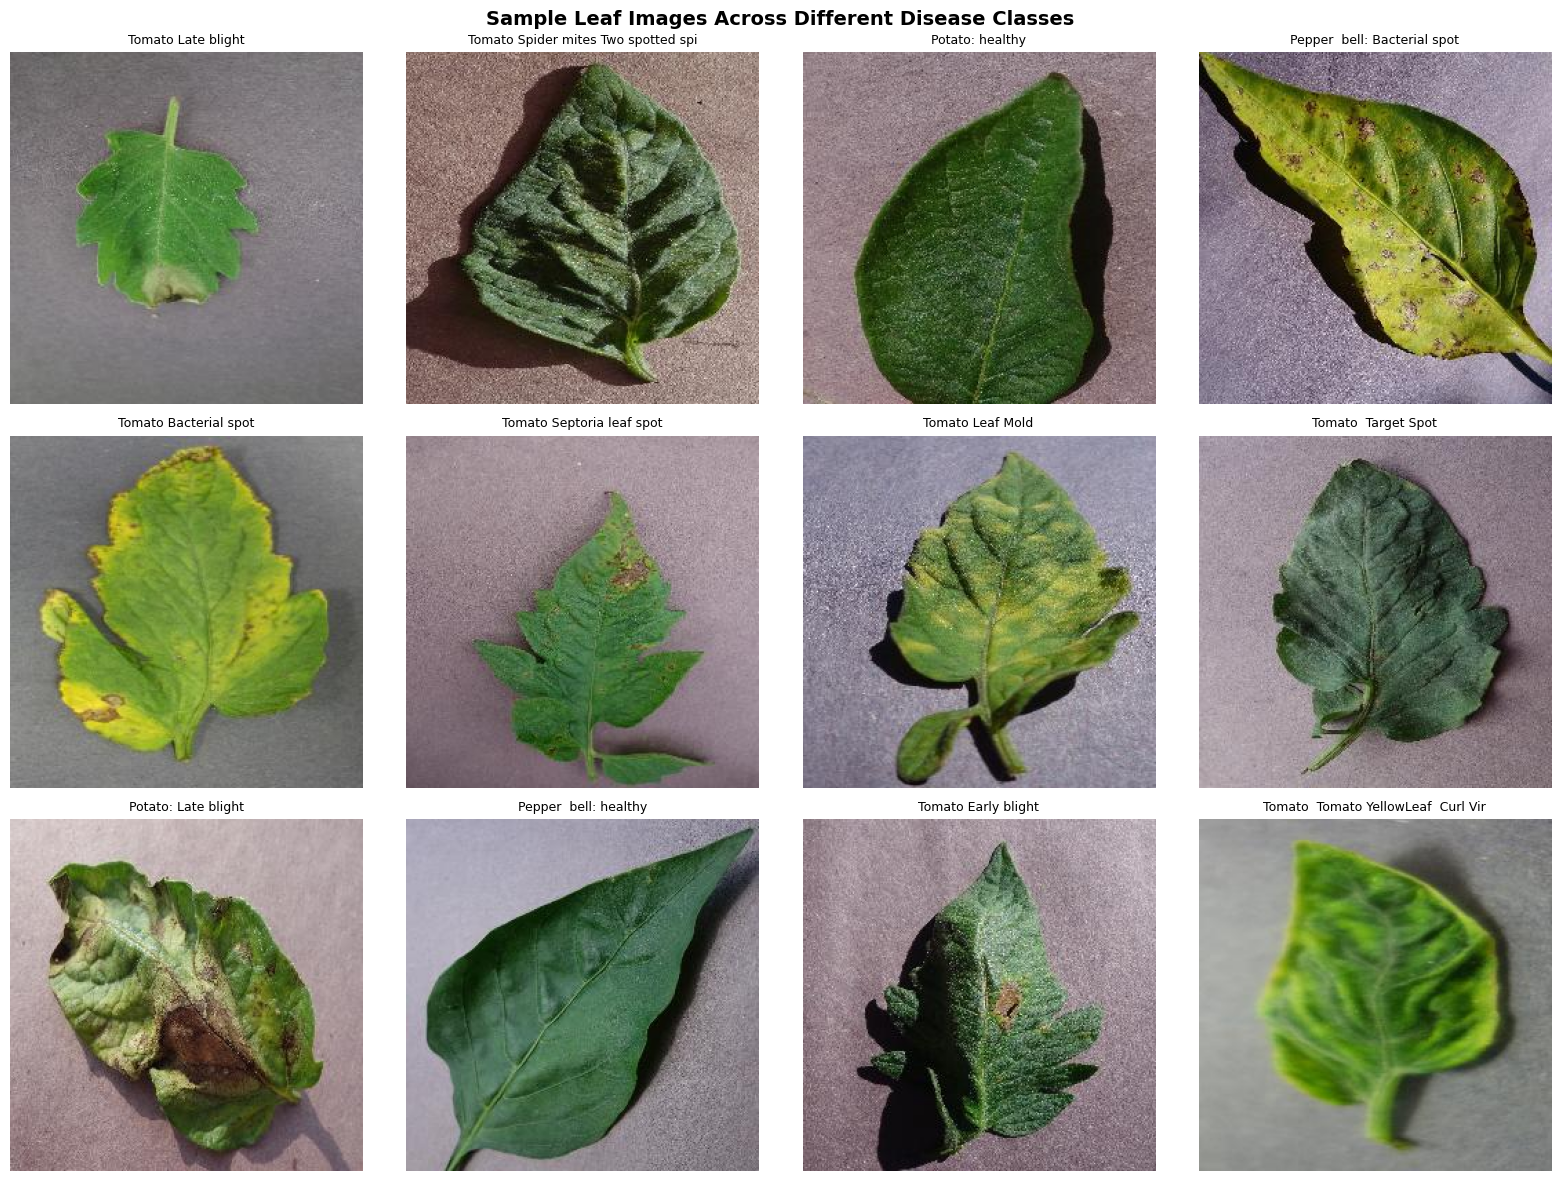

In [4]:
# Display sample images from dataset
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

np.random.seed(123)
sample_classes = np.random.choice(class_names, min(12, len(class_names)), replace=False)

for idx, class_name in enumerate(sample_classes):
    folder_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random_image = np.random.choice(image_files)
    
    image_path = os.path.join(folder_path, random_image)
    image = Image.open(image_path)
    
    axes[idx].imshow(image)
    axes[idx].set_title(class_name.replace('___', ': ').replace('_', ' ')[:35], 
                       fontsize=9, pad=6)
    axes[idx].axis('off')

plt.suptitle('Sample Leaf Images Across Different Disease Classes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# Preprocessing: Data augmentation for training
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocessing: Standard transforms for validation and testing
standard_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Preprocessing Pipeline:")
print("  Training: Augmentation (Flips, Rotation, Color Jitter) + Normalization")
print("  Validation/Test: Resizing + Normalization")

Preprocessing Pipeline:
  Training: Augmentation (Flips, Rotation, Color Jitter) + Normalization
  Validation/Test: Resizing + Normalization


In [6]:
# Load all images from dataset
complete_dataset = torchvision.datasets.ImageFolder(
    root=dataset_path,
    transform=augmentation_transforms
)

print(f"Total dataset size: {len(complete_dataset):,} images")
print(f"Number of classes: {len(complete_dataset.classes)}")
print(f"\nClass mapping (first 5):")
for i, (cls, idx) in enumerate(list(complete_dataset.class_to_idx.items())[:5]):
    print(f"  {cls[:40]}: {idx}")

Total dataset size: 20,638 images
Number of classes: 15

Class mapping (first 5):
  Pepper__bell___Bacterial_spot: 0
  Pepper__bell___healthy: 1
  Potato___Early_blight: 2
  Potato___Late_blight: 3
  Potato___healthy: 4


In [7]:
# Split dataset: 70% training, 15% validation, 15% testing
total_size = len(complete_dataset)
training_size = int(0.7 * total_size)
validation_size = int(0.15 * total_size)
testing_size = total_size - training_size - validation_size

print("="*70)
print("DATASET SPLIT")
print("="*70)
print(f"Training set:   {training_size:6,} images ({training_size/total_size*100:.1f}%)")
print(f"Validation set: {validation_size:6,} images ({validation_size/total_size*100:.1f}%)")
print(f"Test set:       {testing_size:6,} images ({testing_size/total_size*100:.1f}%)")

# Perform random split with fixed seed for reproducibility
torch.manual_seed(123)
train_split, val_split, test_split = torch.utils.data.random_split(
    complete_dataset, 
    [training_size, validation_size, testing_size]
)

DATASET SPLIT
Training set:   14,446 images (70.0%)
Validation set:  3,095 images (15.0%)
Test set:        3,097 images (15.0%)


In [8]:
# Apply transforms to each split
train_split.dataset.transform = augmentation_transforms
val_split.dataset.transform = standard_transforms
test_split.dataset.transform = standard_transforms

print("Transforms successfully applied to all dataset splits")

Transforms successfully applied to all dataset splits


In [9]:
# Create data loaders for batch processing
batch_size = 32

train_dataloader = DataLoader(
    train_split,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_dataloader = DataLoader(
    val_split,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataloader = DataLoader(
    test_split,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print("="*70)
print("DATA LOADERS INITIALIZED")
print("="*70)
print(f"Batch size: {batch_size}")
print(f"Training batches:   {len(train_dataloader):4,}")
print(f"Validation batches: {len(val_dataloader):4,}")
print(f"Test batches:       {len(test_dataloader):4,}")

# Verify data pipeline
sample_batch, sample_labels = next(iter(train_dataloader))
print(f"\nData pipeline verified:")
print(f"  Batch shape: {sample_batch.shape}")
print(f"  Value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

DATA LOADERS INITIALIZED
Batch size: 32
Training batches:    452
Validation batches:   97
Test batches:         97

Data pipeline verified:
  Batch shape: torch.Size([32, 3, 224, 224])
  Value range: [-2.118, 2.553]


In [10]:
# Model 1: ResNet50 with Transfer Learning
def build_resnet50(num_classes):
    model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
    
    # Freeze pre-trained layers
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    # Replace classifier head
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)
    )
    
    return model

# Model 2: EfficientNet-B0 with Transfer Learning
def build_efficientnet(num_classes):
    model = torchvision.models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
    
    # Freeze pre-trained layers
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    # Replace classifier head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)
    )
    
    return model

# Initialize both models
resnet_model = build_resnet50(num_classes).to(device)
efficientnet_model = build_efficientnet(num_classes).to(device)

print("="*70)
print("DEEP LEARNING MODELS INITIALIZED")
print("="*70)
print(f"Model 1: ResNet50")
print(f"  Trainable params: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")
print(f"\nModel 2: EfficientNet-B0")
print(f"  Trainable params: {sum(p.numel() for p in efficientnet_model.parameters() if p.requires_grad):,}")

DEEP LEARNING MODELS INITIALIZED
Model 1: ResNet50
  Trainable params: 30,735

Model 2: EfficientNet-B0
  Trainable params: 19,215


In [11]:
# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=4, min_improvement=0.001):
        self.patience = patience
        self.min_improvement = min_improvement
        self.counter = 0
        self.best_loss = None
        self.should_stop = False
        
    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss > self.best_loss - self.min_improvement:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = validation_loss
            self.counter = 0

# Training function
def train_deep_learning_model(model, train_loader, val_loader, loss_fn, optimizer, 
                               epochs=15, model_name="Model"):
    training_history = {
        'train_loss': [], 'train_accuracy': [],
        'val_loss': [], 'val_accuracy': [],
        'best_val_acc': 0.0
    }
    
    best_accuracy = 0.0
    best_state = None
    early_stop = EarlyStopping(patience=4, min_improvement=0.001)
    
    print(f"\n{'='*70}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*70}\n")
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 40)
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_samples = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item()
            _, predicted_labels = torch.max(predictions, 1)
            train_samples += labels.size(0)
            train_correct += (predicted_labels == labels).sum().item()
            
            # Show progress
            if (batch_idx + 1) % 50 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        train_loss_avg = train_loss_sum / len(train_loader)
        train_acc = 100 * train_correct / train_samples
        
        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_samples = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                predictions = model(images)
                loss = loss_fn(predictions, labels)
                
                val_loss_sum += loss.item()
                _, predicted_labels = torch.max(predictions, 1)
                val_samples += labels.size(0)
                val_correct += (predicted_labels == labels).sum().item()
        
        val_loss_avg = val_loss_sum / len(val_loader)
        val_acc = 100 * val_correct / val_samples
        
        # Save metrics
        training_history['train_loss'].append(train_loss_avg)
        training_history['train_accuracy'].append(train_acc)
        training_history['val_loss'].append(val_loss_avg)
        training_history['val_accuracy'].append(val_acc)
        
        # Track best model
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_state = model.state_dict().copy()
            print(f"✓ New best validation accuracy: {best_accuracy:.2f}%")
        
        epoch_duration = time.time() - epoch_start
        
        print(f"Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Epoch completed in {epoch_duration:.2f}s\n")
        
        # Check early stopping
        early_stop(val_loss_avg)
        if early_stop.should_stop:
            print(f"⚠ Early stopping (no improvement for {early_stop.patience} epochs)\n")
            break
    
    # Load best model weights
    model.load_state_dict(best_state)
    training_history['best_val_acc'] = best_accuracy
    total_duration = time.time() - start_time
    
    print(f"{'='*70}")
    print(f"Training finished in {total_duration/60:.1f} minutes")
    print(f"Best validation accuracy: {best_accuracy:.2f}%")
    print(f"{'='*70}\n")
    
    return training_history

print("Training pipeline configured")

Training pipeline configured


In [12]:
# Define loss function and optimizer for ResNet50
loss_function = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)

print("Starting ResNet50 training...")
resnet_history = train_deep_learning_model(
    model=resnet_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_fn=loss_function,
    optimizer=resnet_optimizer,
    epochs=15,
    model_name="ResNet50"
)

print(f"ResNet50 training completed!")
print(f"Best validation accuracy: {resnet_history['best_val_acc']:.2f}%")

Starting ResNet50 training...

TRAINING: ResNet50

Epoch 1/15
----------------------------------------
Batch 50/452, Loss: 1.4214
Batch 100/452, Loss: 1.0187
Batch 150/452, Loss: 0.9508
Batch 200/452, Loss: 0.6317
Batch 250/452, Loss: 0.4763
Batch 300/452, Loss: 0.5915
Batch 350/452, Loss: 0.7019
Batch 400/452, Loss: 0.5900
Batch 450/452, Loss: 0.7128
✓ New best validation accuracy: 88.76%
Train Loss: 0.8615, Train Acc: 75.17%
Val Loss: 0.4056, Val Acc: 88.76%
Epoch completed in 83.82s

Epoch 2/15
----------------------------------------
Batch 50/452, Loss: 0.2446
Batch 100/452, Loss: 0.3537
Batch 150/452, Loss: 0.4867
Batch 200/452, Loss: 0.8123
Batch 250/452, Loss: 0.3781
Batch 300/452, Loss: 0.4854
Batch 350/452, Loss: 0.4504
Batch 400/452, Loss: 0.2645
Batch 450/452, Loss: 0.4049
Train Loss: 0.4515, Train Acc: 85.95%
Val Loss: 0.3496, Val Acc: 88.66%
Epoch completed in 59.83s

Epoch 3/15
----------------------------------------
Batch 50/452, Loss: 0.4259
Batch 100/452, Loss: 0.3229

In [13]:
# Define optimizer for EfficientNet-B0
efficientnet_optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)

print("Starting EfficientNet-B0 training...")
efficientnet_history = train_deep_learning_model(
    model=efficientnet_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_fn=loss_function,
    optimizer=efficientnet_optimizer,
    epochs=15,
    model_name="EfficientNet-B0"
)

print(f"EfficientNet-B0 training completed!")
print(f"Best validation accuracy: {efficientnet_history['best_val_acc']:.2f}%")

Starting EfficientNet-B0 training...

TRAINING: EfficientNet-B0

Epoch 1/15
----------------------------------------
Batch 50/452, Loss: 1.2638
Batch 100/452, Loss: 0.9586
Batch 150/452, Loss: 0.7873
Batch 200/452, Loss: 0.6104
Batch 250/452, Loss: 0.5986
Batch 300/452, Loss: 0.6286
Batch 350/452, Loss: 0.4388
Batch 400/452, Loss: 0.6544
Batch 450/452, Loss: 0.5983
✓ New best validation accuracy: 90.73%
Train Loss: 0.8623, Train Acc: 78.28%
Val Loss: 0.3804, Val Acc: 90.73%
Epoch completed in 37.90s

Epoch 2/15
----------------------------------------
Batch 50/452, Loss: 0.3287
Batch 100/452, Loss: 0.5415
Batch 150/452, Loss: 0.3892
Batch 200/452, Loss: 0.2348
Batch 250/452, Loss: 0.2696
Batch 300/452, Loss: 0.3825
Batch 350/452, Loss: 0.4211
Batch 400/452, Loss: 0.3558
Batch 450/452, Loss: 0.3874
✓ New best validation accuracy: 92.12%
Train Loss: 0.4194, Train Acc: 87.80%
Val Loss: 0.2765, Val Acc: 92.12%
Epoch completed in 34.26s

Epoch 3/15
----------------------------------------
B

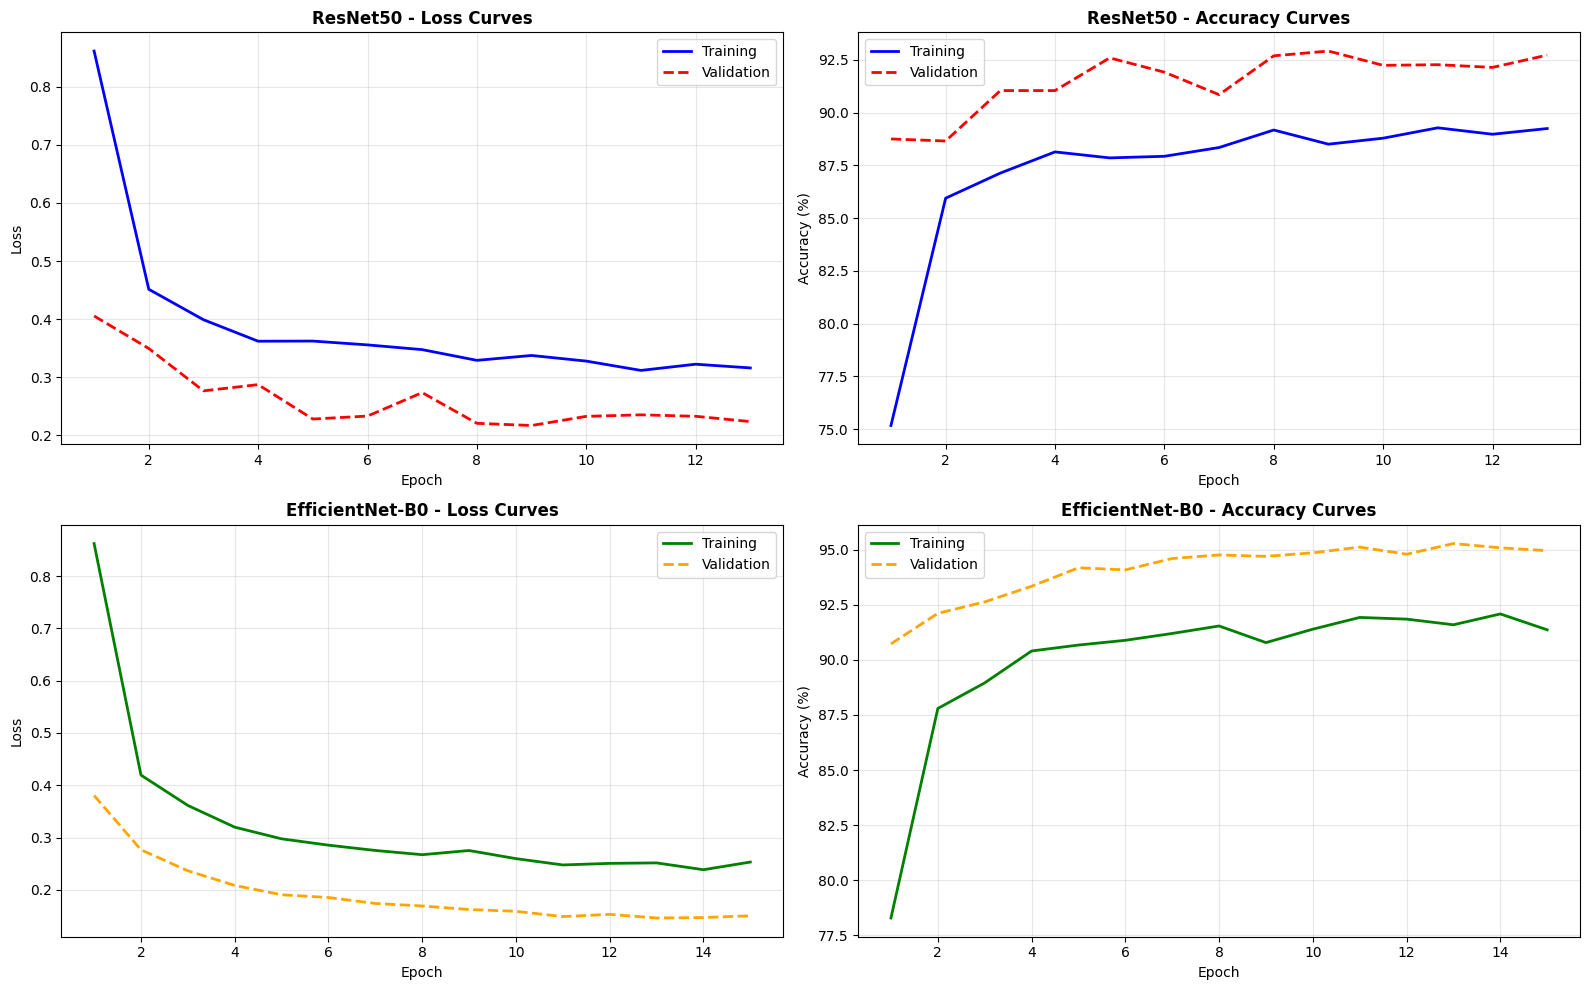

In [14]:
# Plot training and validation curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

resnet_epochs = range(1, len(resnet_history['train_loss']) + 1)
efficient_epochs = range(1, len(efficientnet_history['train_loss']) + 1)

# ResNet50 Loss
axes[0, 0].plot(resnet_epochs, resnet_history['train_loss'], 'b-', label='Training', linewidth=2)
axes[0, 0].plot(resnet_epochs, resnet_history['val_loss'], 'r--', label='Validation', linewidth=2)
axes[0, 0].set_title('ResNet50 - Loss Curves', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ResNet50 Accuracy
axes[0, 1].plot(resnet_epochs, resnet_history['train_accuracy'], 'b-', label='Training', linewidth=2)
axes[0, 1].plot(resnet_epochs, resnet_history['val_accuracy'], 'r--', label='Validation', linewidth=2)
axes[0, 1].set_title('ResNet50 - Accuracy Curves', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# EfficientNet Loss
axes[1, 0].plot(efficient_epochs, efficientnet_history['train_loss'], 'g-', label='Training', linewidth=2)
axes[1, 0].plot(efficient_epochs, efficientnet_history['val_loss'], 'orange', linestyle='--', label='Validation', linewidth=2)
axes[1, 0].set_title('EfficientNet-B0 - Loss Curves', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# EfficientNet Accuracy
axes[1, 1].plot(efficient_epochs, efficientnet_history['train_accuracy'], 'g-', label='Training', linewidth=2)
axes[1, 1].plot(efficient_epochs, efficientnet_history['val_accuracy'], 'orange', linestyle='--', label='Validation', linewidth=2)
axes[1, 1].set_title('EfficientNet-B0 - Accuracy Curves', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Model evaluation function
def evaluate_on_test(model, test_loader, model_name):
    model.eval()
    predictions_list = []
    labels_list = []
    
    print(f"\nEvaluating {model_name}...")
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            predictions_list.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    
    # Calculate performance metrics
    test_acc = accuracy_score(labels_list, predictions_list) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_list, predictions_list, average='weighted', zero_division=0
    )
    
    print(f"\n{'='*70}")
    print(f"{model_name} - TEST SET EVALUATION")
    print(f"{'='*70}")
    print(f"Accuracy:  {test_acc:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    return predictions_list, labels_list, test_acc, precision, recall, f1

# Evaluate both models
resnet_preds, resnet_labels, resnet_acc, resnet_prec, resnet_rec, resnet_f1 = evaluate_on_test(
    resnet_model, test_dataloader, "ResNet50"
)

efficient_preds, efficient_labels, efficient_acc, efficient_prec, efficient_rec, efficient_f1 = evaluate_on_test(
    efficientnet_model, test_dataloader, "EfficientNet-B0"
)


Evaluating ResNet50...

ResNet50 - TEST SET EVALUATION
Accuracy:  92.19%
Precision: 0.9254
Recall:    0.9219
F1-Score:  0.9218

Evaluating EfficientNet-B0...

EfficientNet-B0 - TEST SET EVALUATION
Accuracy:  93.87%
Precision: 0.9393
Recall:    0.9387
F1-Score:  0.9380



BEST PERFORMING MODEL: EfficientNet-B0 (93.87%)


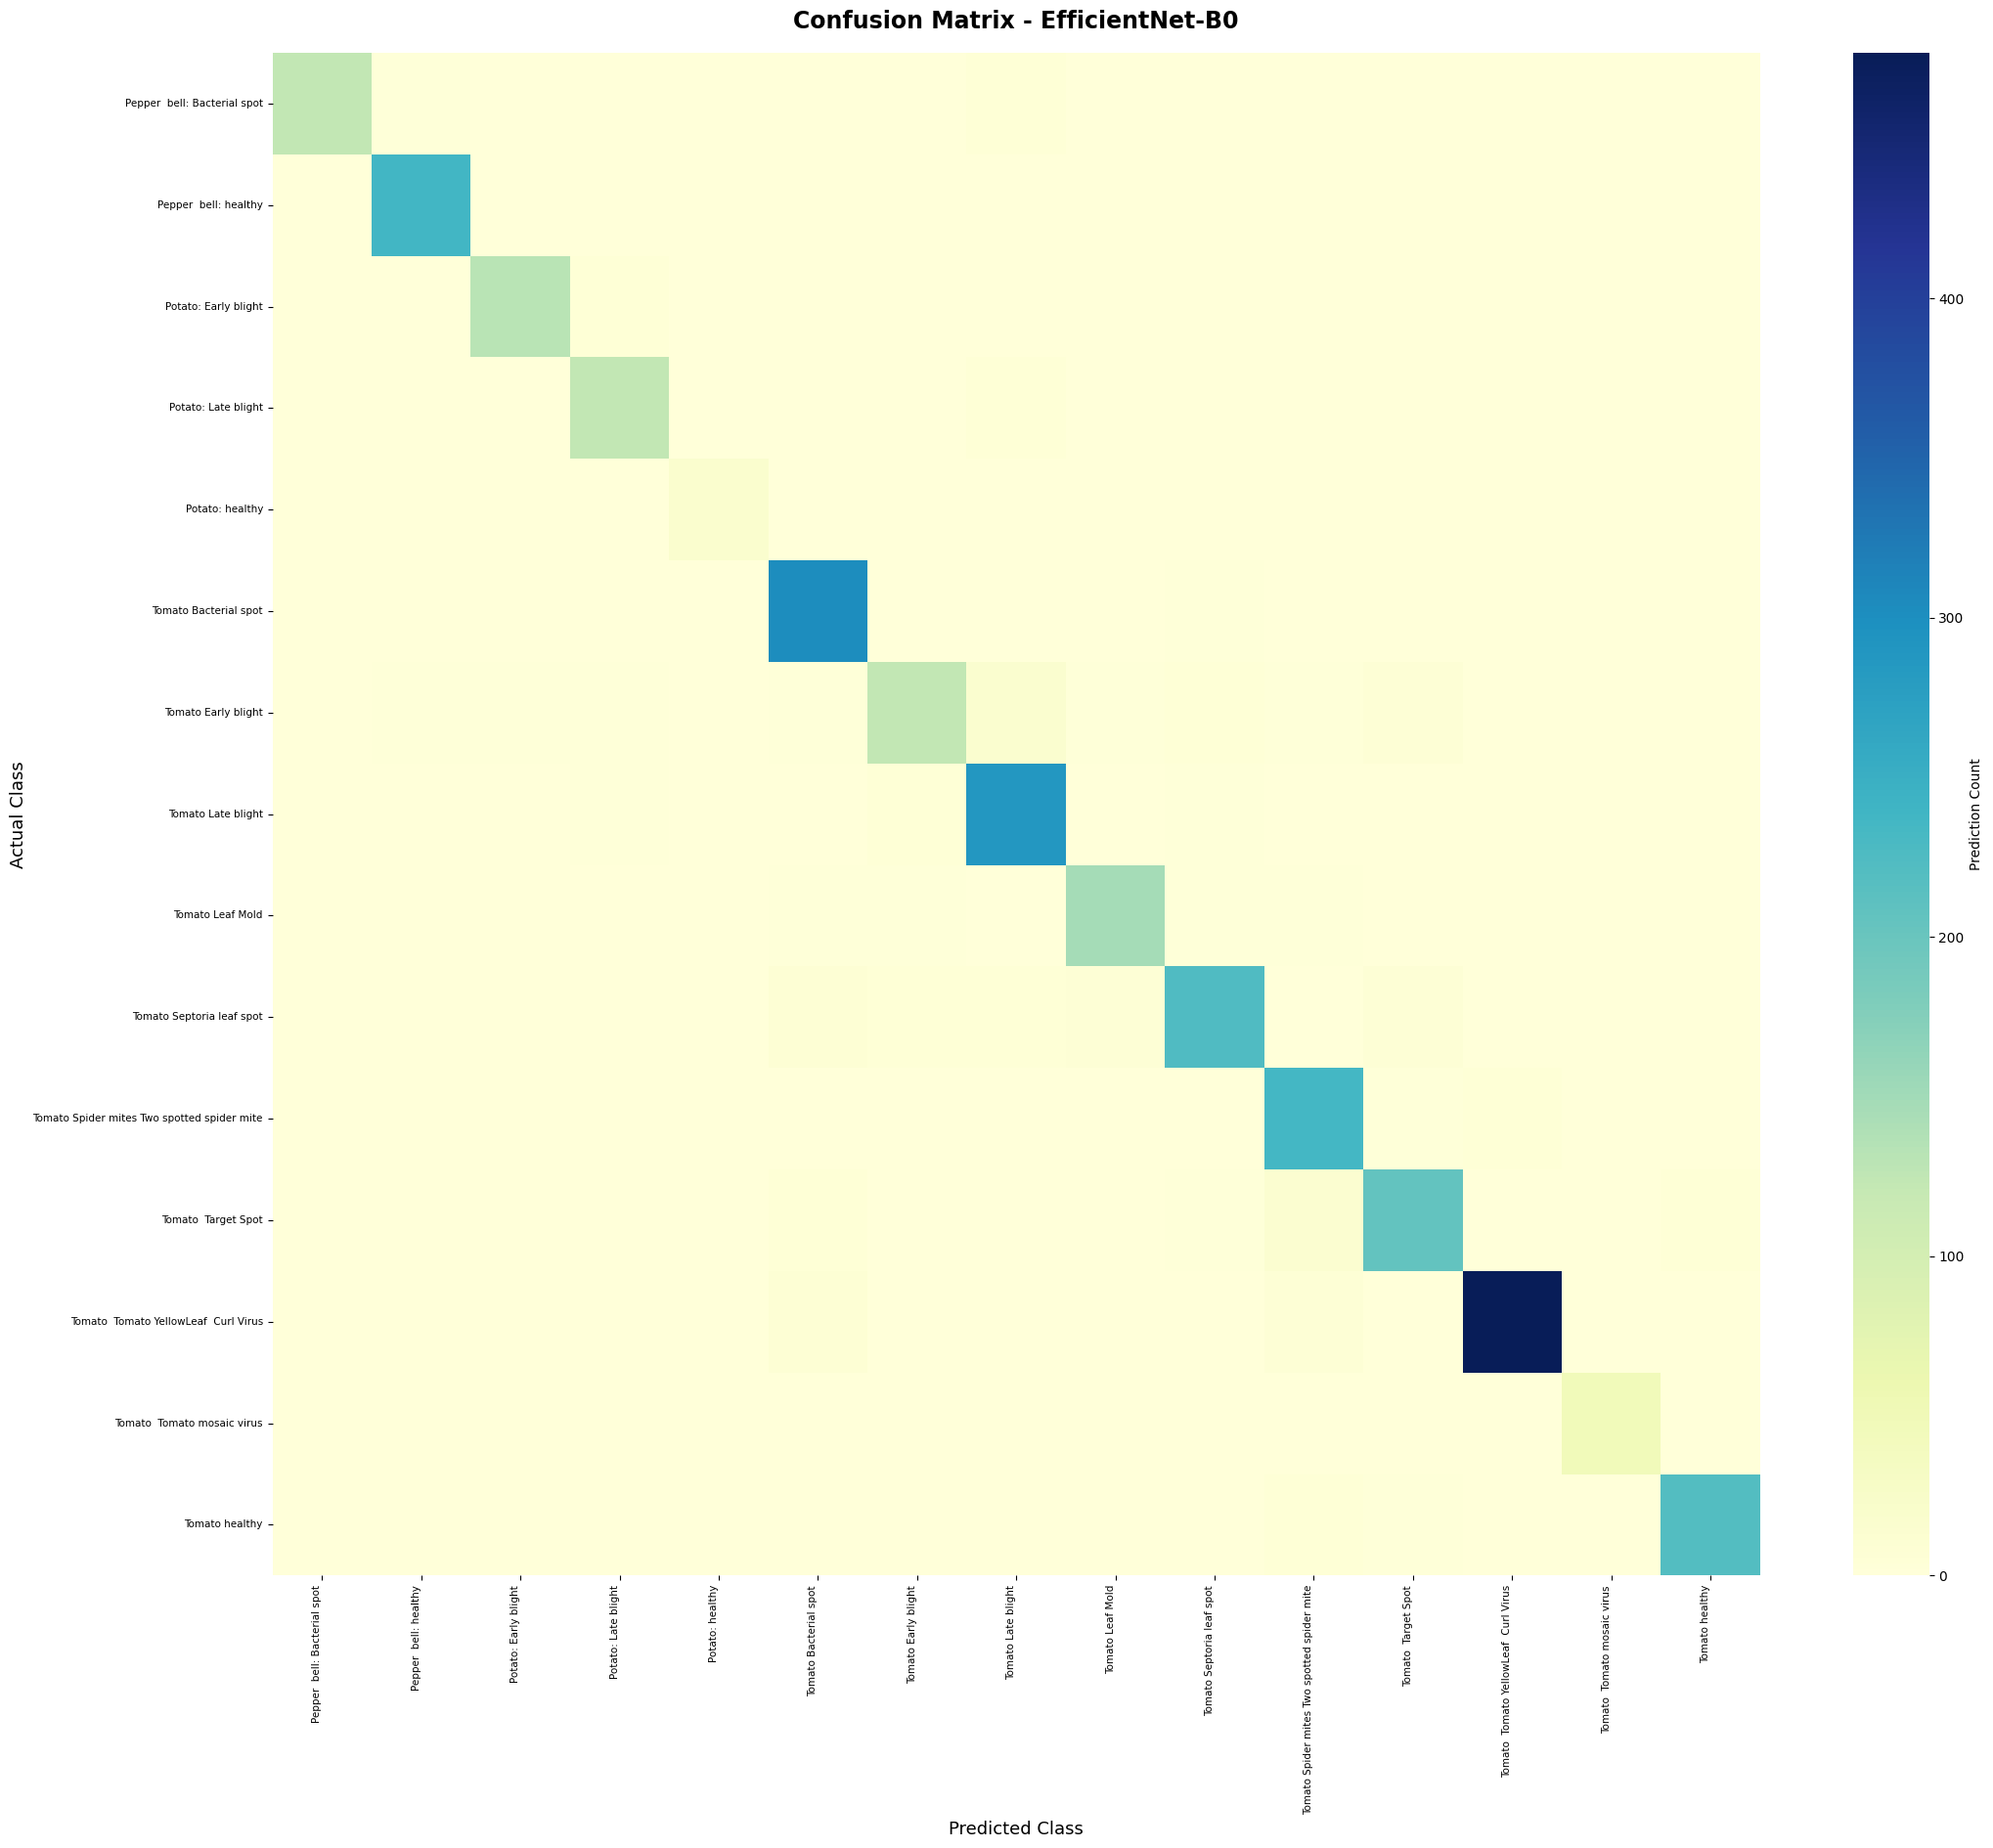


TOP 10 HIGHEST ACCURACY CLASSES
 1. Potato: healthy                             → 100.00%
 2. Pepper  bell: healthy                       → 99.58%
 3. Tomato Bacterial spot                       → 98.38%
 4. Tomato  Tomato YellowLeaf  Curl Virus       → 96.95%
 5. Tomato healthy                              → 96.93%
 6. Tomato Spider mites Two spotted spider mite → 96.72%
 7. Potato: Early blight                        → 96.32%
 8. Tomato  Tomato mosaic virus                 → 96.00%
 9. Pepper  bell: Bacterial spot                → 95.38%
10. Tomato Late blight                          → 94.72%

TOP 10 LOWEST ACCURACY CLASSES
 1. Tomato Early blight                         → 75.00%
 2. Tomato Septoria leaf spot                   → 86.15%
 3. Tomato  Target Spot                         → 87.66%
 4. Tomato Leaf Mold                            → 92.50%
 5. Potato: Late blight                         → 94.62%
 6. Tomato Late blight                          → 94.72%
 7. Pepper  bell: Bact

In [16]:
# Identify best performing model
if efficient_acc > resnet_acc:
    champion_model = "EfficientNet-B0"
    champion_preds = efficient_preds
    champion_labels = efficient_labels
    champion_acc = efficient_acc
else:
    champion_model = "ResNet50"
    champion_preds = resnet_preds
    champion_labels = resnet_labels
    champion_acc = resnet_acc

print(f"\n{'='*70}")
print(f"BEST PERFORMING MODEL: {champion_model} ({champion_acc:.2f}%)")
print(f"{'='*70}")

# Create confusion matrix
conf_matrix = confusion_matrix(champion_labels, champion_preds)

# Visualize confusion matrix
plt.figure(figsize=(22, 19))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='YlGnBu', 
            xticklabels=[c.replace('___', ': ').replace('_', ' ') for c in class_names],
            yticklabels=[c.replace('___', ': ').replace('_', ' ') for c in class_names],
            cbar_kws={'label': 'Prediction Count'})
plt.title(f'Confusion Matrix - {champion_model}', fontsize=17, fontweight='bold', pad=18)
plt.xlabel('Predicted Class', fontsize=13)
plt.ylabel('Actual Class', fontsize=13)
plt.xticks(rotation=90, ha='right', fontsize=7.5)
plt.yticks(rotation=0, fontsize=7.5)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
per_class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100

print("\n" + "="*70)
print("TOP 10 HIGHEST ACCURACY CLASSES")
print("="*70)
best_classes = np.argsort(per_class_acc)[::-1][:10]
for rank, idx in enumerate(best_classes, 1):
    print(f"{rank:2d}. {class_names[idx].replace('___', ': ').replace('_', ' '):43s} → {per_class_acc[idx]:.2f}%")

print("\n" + "="*70)
print("TOP 10 LOWEST ACCURACY CLASSES")
print("="*70)
worst_classes = np.argsort(per_class_acc)[:10]
for rank, idx in enumerate(worst_classes, 1):
    print(f"{rank:2d}. {class_names[idx].replace('___', ': ').replace('_', ' '):43s} → {per_class_acc[idx]:.2f}%")

In [17]:
print(f"\n{'='*100}")
print(f"COMPREHENSIVE CLASSIFICATION REPORT - {champion_model}")
print(f"{'='*100}\n")

classification_rep = classification_report(
    champion_labels, 
    champion_preds, 
    target_names=[c.replace('___', ': ').replace('_', ' ') for c in class_names],
    digits=4
)
print(classification_rep)


COMPREHENSIVE CLASSIFICATION REPORT - EfficientNet-B0

                                             precision    recall  f1-score   support

               Pepper  bell: Bacterial spot     0.9764    0.9538    0.9650       130
                      Pepper  bell: healthy     0.9754    0.9958    0.9855       239
                       Potato: Early blight     0.9704    0.9632    0.9668       136
                        Potato: Late blight     0.9248    0.9462    0.9354       130
                            Potato: healthy     0.9474    1.0000    0.9730        18
                      Tomato Bacterial spot     0.9182    0.9838    0.9498       308
                        Tomato Early blight     0.9111    0.7500    0.8227       164
                         Tomato Late blight     0.8969    0.9472    0.9213       303
                           Tomato Leaf Mold     0.9308    0.9250    0.9279       160
                  Tomato Septoria leaf spot     0.9372    0.8615    0.8978       260
Tomato S

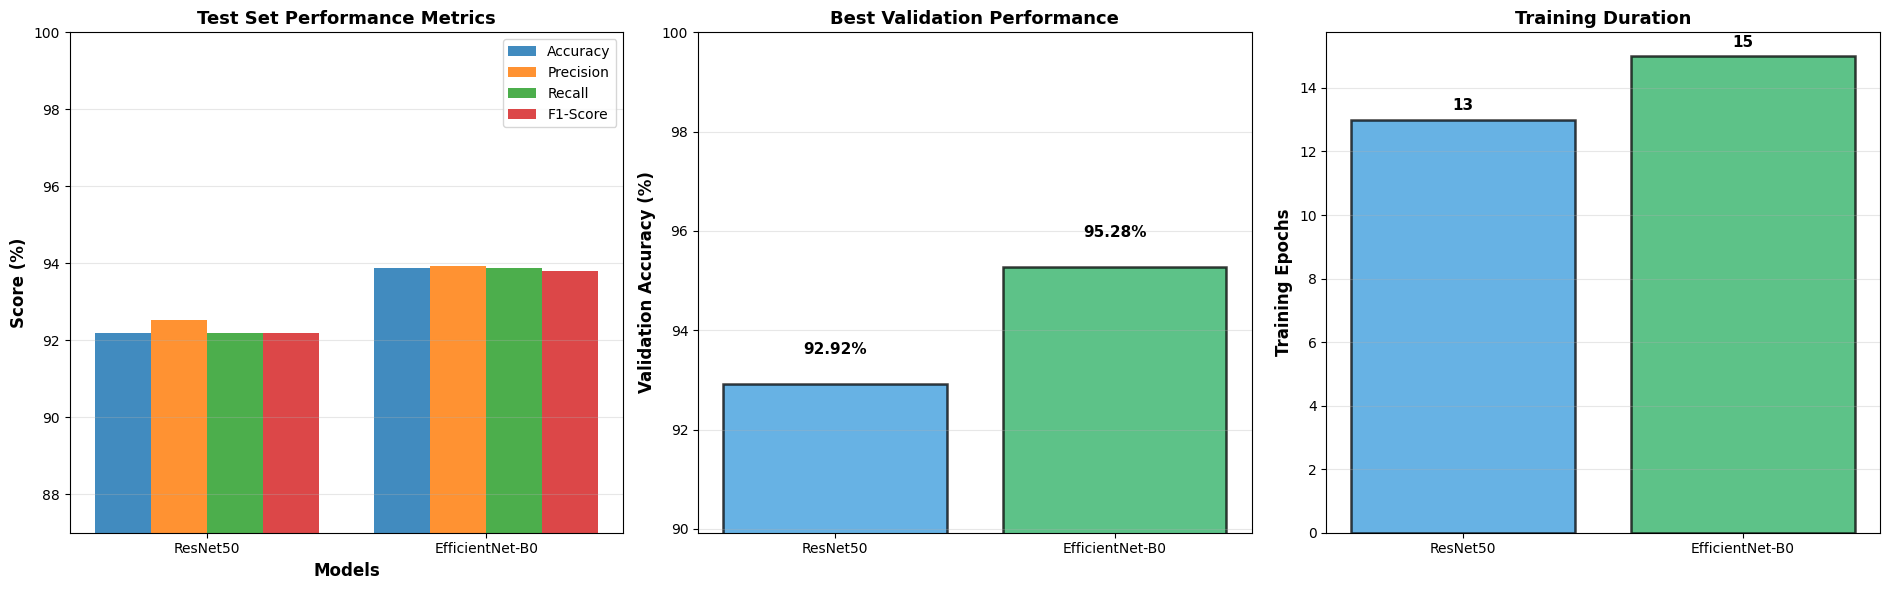

In [18]:
# Performance comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(19, 6))
model_names = ['ResNet50', 'EfficientNet-B0']

# Test metrics comparison
performance_metrics = {
    'Accuracy': [resnet_acc, efficient_acc],
    'Precision': [resnet_prec * 100, efficient_prec * 100],
    'Recall': [resnet_rec * 100, efficient_rec * 100],
    'F1-Score': [resnet_f1 * 100, efficient_f1 * 100]
}

x_pos = np.arange(len(model_names))
bar_width = 0.2

for i, (metric, values) in enumerate(performance_metrics.items()):
    axes[0].bar(x_pos + i*bar_width, values, bar_width, label=metric, alpha=0.85)

axes[0].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Test Set Performance Metrics', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos + bar_width * 1.5)
axes[0].set_xticklabels(model_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([87, 100])

# Validation accuracy comparison
axes[1].bar(model_names, [resnet_history['best_val_acc'], efficientnet_history['best_val_acc']], 
            color=['#3498db', '#27ae60'], alpha=0.75, edgecolor='black', linewidth=1.8)
axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Best Validation Performance', fontsize=13, fontweight='bold')
axes[1].set_ylim([min(resnet_history['best_val_acc'], efficientnet_history['best_val_acc']) - 3, 100])

for i, (name, acc) in enumerate(zip(model_names, [resnet_history['best_val_acc'], efficientnet_history['best_val_acc']])):
    axes[1].text(i, acc + 0.6, f'{acc:.2f}%', ha='center', fontweight='bold', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Training efficiency
epochs_completed = [len(resnet_history['train_loss']), len(efficientnet_history['train_loss'])]
axes[2].bar(model_names, epochs_completed, color=['#3498db', '#27ae60'], alpha=0.75, edgecolor='black', linewidth=1.8)
axes[2].set_ylabel('Training Epochs', fontsize=12, fontweight='bold')
axes[2].set_title('Training Duration', fontsize=13, fontweight='bold')

for i, (name, ep) in enumerate(zip(model_names, epochs_completed)):
    axes[2].text(i, ep + 0.3, f'{ep}', ha='center', fontweight='bold', fontsize=11)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Create directory for model checkpoints
model_save_dir = "plant_disease_trained_models"
os.makedirs(model_save_dir, exist_ok=True)

# Save ResNet50 checkpoint
resnet_checkpoint = os.path.join(model_save_dir, "resnet50_plant_classifier.pth")
torch.save({
    'model_state': resnet_model.state_dict(),
    'classes': class_names,
    'num_classes': num_classes,
    'test_metrics': {
        'accuracy': resnet_acc,
        'precision': resnet_prec,
        'recall': resnet_rec,
        'f1_score': resnet_f1
    },
    'best_val_acc': resnet_history['best_val_acc'],
    'history': resnet_history
}, resnet_checkpoint)

# Save EfficientNet checkpoint
efficient_checkpoint = os.path.join(model_save_dir, "efficientnet_plant_classifier.pth")
torch.save({
    'model_state': efficientnet_model.state_dict(),
    'classes': class_names,
    'num_classes': num_classes,
    'test_metrics': {
        'accuracy': efficient_acc,
        'precision': efficient_prec,
        'recall': efficient_rec,
        'f1_score': efficient_f1
    },
    'best_val_acc': efficientnet_history['best_val_acc'],
    'history': efficientnet_history
}, efficient_checkpoint)

print("="*70)
print("MODEL CHECKPOINTS SAVED")
print("="*70)
print(f"Directory: {os.path.abspath(model_save_dir)}/")
print(f"\nCheckpoint files:")
print(f"  1. resnet50_plant_classifier.pth")
print(f"  2. efficientnet_plant_classifier.pth")

MODEL CHECKPOINTS SAVED
Directory: C:\Users\isuru\Downloads\plant_disease_trained_models/

Checkpoint files:
  1. resnet50_plant_classifier.pth
  2. efficientnet_plant_classifier.pth
